Compare journies
================

Compare the travel time when I cycle home via the A3 vs when I come via Richmond Park. 

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
# See Line Through Circle notebook for a description of these
def lines_cross(x1,x2,y1,y2) -> bool:

    a = x2[0]-x1[0]
    b = y1[0]-y2[0]
    c = x2[1]-x1[1]
    d = y1[1]-y2[1]

    Minv = 1 / (a*d - b*c) * np.array([[d, -b],[-c,a]])
    alpha_beta = Minv @ (y1 - x1)

    return all((0 <= alpha_beta )& (alpha_beta <= 1))

def get_circle_points(c,r,x1,x2):
    v = x1-x2
    u = (1 / np.sqrt(np.dot(v,v))) * np.array([[0,1],[-1,0]]) @ v

    c1 = c - r * u
    c2 = c + r * u
    
    return c1,c2

def does_line_go_through_circle(c,r,x1,x2):
    y1, y2 = get_circle_points(c,r,x1,x2)
    return lines_cross(x1,x2,y1,y2)

In [25]:
location_log = pd.read_csv("locations.csv").set_index("time").sort_index()
location_log

,entity_id,latitude,longitude
time,,,
2022-05-06 03:15:07.110833,person.gaby,51.409610,-0.280304
2022-05-06 03:20:23.946649,person.gaby,51.409616,-0.280316
2022-05-06 03:24:58.453512,person.gaby,51.409622,-0.280314
2022-05-06 03:30:02.878928,person.gaby,51.409595,-0.280277
2022-05-06 03:38:07.624507,person.gaby,51.409629,-0.280312
...,...,...,...
2022-10-23 10:38:46.192274,person.gaby,51.409737,-0.280182
2022-10-23 10:43:17.976969,person.gaby,51.409736,-0.280219
2022-10-23 10:44:48.313036,person.gaby,51.409736,-0.280214


In [26]:
LOCATIONS = {
    "imperial": (51.4996119163838, -0.1793120020929193),
    "home": (51.409812979622174, -0.28017411558994054),
    "richmond_park": (51.45393576302114, -0.2572030264957135),
    "A3": (51.446922160476056, -0.22615622806043198),
    
}
RADIUS = 100  # meters

# Latitude: 1 deg = 110.574 km
# Longitude: 1 deg = 111.320*cos(latitude) km
def latlong_vec_to_meters(lat, vec):
    lat = np.reshape(np.array(lat), (-1, 1))
    vec = np.reshape(np.array(vec), (-1, 2))
    
    cos_lat = np.cos(lat * np.pi / 180.0)
    conversion_mat = np.hstack([np.ones_like(vec[:,[0]])*110574, cos_lat * 111320])
    return (conversion_mat * vec).squeeze()

print(latlong_vec_to_meters(51.4996119163838, [1,1]))
print(latlong_vec_to_meters([51.4996119163838, 51.4996119163838], [[1,1], [0.5,0.5]]))

[110574.          69298.91944161]
[[110574.          69298.91944161]
 [ 55287.          34649.45972081]]


Convert all coordinates to vectors in metres, using home as a reference

In [27]:
REFERENCE_XY = LOCATIONS["home"]

def to_xy(latlong):
    latlong = np.reshape(np.array(latlong), (-1, 2))
    return latlong_vec_to_meters(
        latlong[:, 0],
        latlong - REFERENCE_XY
    )

location_log.loc[:, ["x","y"]] = to_xy(location_log.loc[:, ["latitude", "longitude"]].to_numpy())

location_log

,entity_id,latitude,longitude,x,y
time,,,,,
2022-05-06 03:15:07.110833,person.gaby,51.409610,-0.280304,-22.400039,-9.025556
2022-05-06 03:20:23.946649,person.gaby,51.409616,-0.280316,-21.736595,-9.831009
2022-05-06 03:24:58.453512,person.gaby,51.409622,-0.280314,-21.062094,-9.719911
2022-05-06 03:30:02.878928,person.gaby,51.409595,-0.280277,-24.113936,-7.171626
2022-05-06 03:38:07.624507,person.gaby,51.409629,-0.280312,-20.343363,-9.587981
...,...,...,...,...,...
2022-10-23 10:38:46.192274,person.gaby,51.409737,-0.280182,-8.368199,-0.561345
2022-10-23 10:43:17.976969,person.gaby,51.409736,-0.280219,-8.500887,-3.144345
2022-10-23 10:44:48.313036,person.gaby,51.409736,-0.280214,-8.489830,-2.790224


In [28]:
# location_log.loc[:, ["dx","dy"]] = location_log.loc[:, ["x", "y"]].diff().to_numpy()
# location_log

## Label all points by which location they are in

In [29]:
location_log["place"] = None

for place_name, place_coords in LOCATIONS.items():
    place_xy = to_xy(place_coords)
    
    vecs_to_place_latlong = location_log.loc[:, ["latitude","longitude"]] - place_coords
    vecs_to_place_m = pd.DataFrame(
        latlong_vec_to_meters(location_log.loc[:,"latitude"], vecs_to_place_latlong),
        index=location_log.index,
        columns=["latitude","longitude"]
    )
    k_close = np.linalg.norm(vecs_to_place_m, axis=1) < RADIUS
    if any(location_log.loc[k_close, "place"].notna()):
        raise ValueError("Some locations are found twice")
    location_log.loc[k_close, "place"] = place_name

In [30]:
location_log["place"].unique()

array(['home', None, 'imperial', 'richmond_park', 'A3'], dtype=object)

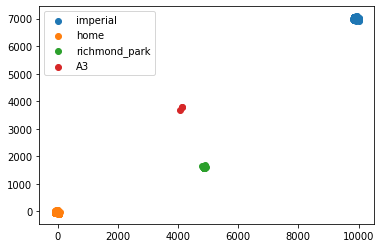

In [31]:
plt.figure()
for place_name in LOCATIONS.keys():
    k = location_log["place"] == place_name
    plt.scatter(location_log.loc[k, "x"],location_log.loc[k, "y"])

plt.legend(LOCATIONS.keys());

## Check if we pass through the A3 circle

In [32]:
does_line_go_through_circle?

Signature: does_line_go_through_circle(c, r, x1, x2)
Docstring: <no docstring>
File:      /tmp/ipykernel_1201/2291374176.py
Type:      function


In [58]:
points = location_log.loc[:,["x","y"]].to_numpy()
points

array([[-22.40003914,  -9.02555631],
       [-21.73659514,  -9.83100894],
       [-21.06209374,  -9.71991057],
       ...,
       [ -8.48982994,  -2.79022429],
       [ -7.81532854,   2.05637279],
       [ -9.05375734,   3.59089784]])

In [94]:
ps = np.hstack((points[:-1,:],points[1:,:]))

through_a3 = np.apply_along_axis(lambda x :
    does_line_go_through_circle(LOCATIONS["A3"], RADIUS, x[0:2],x[2:])
                                , 1, ps)
location_log["through_a3"] = np.append(through_a3, False)

/tmp/ipykernel_1201/2291374176.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  u = (1 / np.sqrt(np.dot(v,v))) * np.array([[0,1],[-1,0]]) @ v
/tmp/ipykernel_1201/2291374176.py:16: RuntimeWarning: invalid value encountered in multiply
  u = (1 / np.sqrt(np.dot(v,v))) * np.array([[0,1],[-1,0]]) @ v
/tmp/ipykernel_1201/2291374176.py:16: RuntimeWarning: invalid value encountered in matmul
  u = (1 / np.sqrt(np.dot(v,v))) * np.array([[0,1],[-1,0]]) @ v


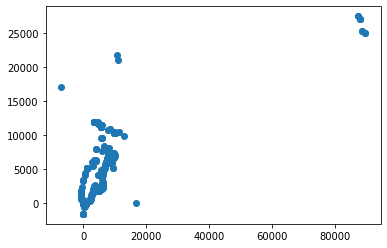

In [96]:
plt.scatter(location_log.loc[location_log["through_a3"], "x"], location_log.loc[location_log["through_a3"], "y"])